---
title: 10.4 随机梯度下降
date: 2024-8-7 12:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
# 4 随机梯度下降

## 4.1 随机梯度更新

- 深度学习中，目标函数通常是训练数据集中每个样本的损失函数的平均值:
$$ f( \mathbf{ x } ) = \frac{1}{n} \sum_{i=1}^{n} f_i( \mathbf{ x } ) $$
- $\mathbf{ x }$的目标函数的梯度:
$$ \nabla f( \mathbf{ x } ) = \frac{1}{n} \sum_{i=1}^{n} \nabla f_i( \mathbf{ x } ) $$

- 如果使用梯度下降法，则每个自变量迭代的计算代价为O(n)，它随n线性增长。因此，当训练数据集较大时，每次迭代的梯度下降计算代价将较高。

- 随机梯度下降 (SGD) :在每次迭代中，随机采样一个样本$i$，并计算梯度$\nabla f_i( \mathbf{ x } )$来迭代$\mathbf{ x }$:

$$ \mathbf{ x } \leftarrow \mathbf{ x } - \eta \nabla f_i( \mathbf{ x } ) $$

- 需要注意的是: SGD中$\nabla f_i( \mathbf{ x } )$是对梯度$\nabla f( \mathbf{ x } )$的无偏估计, 因为:
$$ E_i \nabla f_i( \mathbf{ x } ) = \frac{1}{n} \sum_{i=1}^{n} \nabla f_i( \mathbf{ x } ) = \nabla f( \mathbf{ x } ) $$

    - 这意味着, 平均而言, 随机梯度是对梯度的一个良好的估计。

- 为了比较梯度下降与SGD, 我们向梯度添加均值为0, 方差为1的随机噪声,以模拟SDG

epoch 50, x1: 0.081862, x2: 0.199564


c:\Users\admin\miniconda3\envs\d2l\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


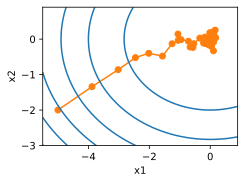

In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l
def f(x1, x2): #目标函数
    return x1 ** 2 + 2 * x2 ** 2
def f_grad(x1, x2): #目标函数的梯度
    return 2 * x1, 4 * x2
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # 模拟有噪声的梯度
    g1 += torch.normal(0.1, 1, (1,)).item()
    g2 += torch.normal(0.1, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)
def constant_lr():
    return 1
eta = 0.1
lr = constant_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

- 即使经过50次迭代，质量仍然不那么好。更糟糕的是，经过额外的步骤，它不会得到改善。这给我们留下了唯一的选择：改变学习率η。但是，如果我们选择的学习率太小，我们一开始就不会取得任何有意义的进展。另一方面，如果我们选择的学习率太大，我们将无法获得一个好的解决方案，解决这些相互冲突的目标的唯一方法是在优化过程中动态降低学习率。

## 4.2 动态学习率

- 用与时间相关的学习率$\eta(t)$替换固定学习率$\eta$增加了控制优化算法收敛的复杂性。

- 我们需要弄清$\eta$的衰减速度。如果太快，我们将过早停止优化。如果减少的太慢，我们会在优化上浪费太多时间。

- 例如:
$$\begin{aligned} & \eta(t) = \eta_i , \space \space if t_i \leq t \leq t_{i+1} ,\space 分段常数 \\
 & \eta(t) = \eta_0 \cdot e^{- \lambda t} , \space \space 指数衰减 \\
 & \eta(t) = \eta_0 \cdot (\beta t + 1)^{- \alpha} , \space \space 多项式衰减 \end{aligned}$$
 
    - 在分段常数中, 我们会降低学习率, 例如, 每当优化进度停顿时。这是训练深度网络的常见策略。
    - 可以通过指数衰减（exponentialdecay）来更积极地减低它。这往往会导致算法收敛之前过早停止。
    - 一个受欢迎的选择是$\alpha = 0.5$的多项式衰减

- 指数衰减，参数的方差大大减少。但是，这是以未能收敛到最优解x=(0,0)为代价的。即使经过1000个迭代步骤，我们仍然离最优解很远。事实上，该算法根本无法收敛. :

epoch 1000, x1: -0.879075, x2: -0.030986


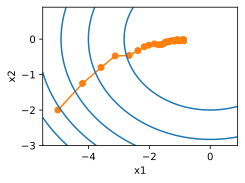

In [2]:
def exponential_lr():
    global t
    t += 1
    return math.exp(-0.1 * t)
t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

- 多项式衰减，其中学习率随迭代次数的平方根倒数衰减，仅在50次迭代之后，收敛就会更好:

epoch 50, x1: -0.068653, x2: 0.002408


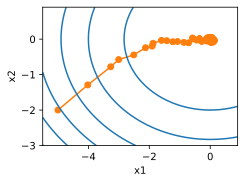

In [3]:
def polynomial_lr():
    global t
    t += 1
    return (1 + 0.1 * t)**(-0.5)
t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

## 4.3 凸目标的收敛性分析

略

## 4.4 随机梯度和有限样本

略
